# Training a Multitask GP model for Computer Model Emulation

Based on this example: https://docs.gpytorch.ai/en/v1.2.0/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

### Import necessary libraries 

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import math
import torch
import gpytorch

In [2]:
from calculations_load import *
from configurations import *

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [3]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [4]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

#perform a transformation of the design, swapping the original parameters
#for inputs more naturally/simply related to the outputs
do_transform_design = True
if do_transform_design:
    X = transform_design(X.values)

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)

Y = np.array([])
for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
        
Y = Y.reshape(X.shape[0], -1)

In [5]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 29)
Y.shape : (485, 110)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

feature_range = (-1, 1)

X_scaler = MinMaxScaler(feature_range = feature_range ).fit(X_train)
Y_scaler = MinMaxScaler(feature_range = feature_range ).fit(Y_train)
#X_scaler = StandardScaler().fit(X_train)
#Y_scaler = StandardScaler().fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

#make the torch tensors
X_train_sc = X_train_sc.astype(np.float32)
Y_train_sc = Y_train_sc.astype(np.float32)
X_train_tensor = torch.from_numpy(X_train_sc)
Y_train_tensor = torch.from_numpy(Y_train_sc)

X_test_sc = X_test_sc.astype(np.float32)
Y_test_sc = Y_test_sc.astype(np.float32)
X_test_tensor = torch.from_numpy(X_test_sc)
Y_test_tensor = torch.from_numpy(Y_test_sc)

### The cell below constructs the Multitask GP model

In [15]:
num_tasks = Y.shape[1]
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
model = MultitaskGPModel(X_train_tensor, Y_train_tensor, likelihood)

In [16]:
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, Y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 529.921
Iter 2/50 - Loss: 513.798
Iter 3/50 - Loss: 498.471
Iter 4/50 - Loss: 483.780
Iter 5/50 - Loss: 469.366
Iter 6/50 - Loss: 454.815
Iter 7/50 - Loss: 439.301
Iter 8/50 - Loss: 423.321
Iter 9/50 - Loss: 405.814
Iter 10/50 - Loss: 388.853
Iter 11/50 - Loss: 369.759
Iter 12/50 - Loss: 351.805
Iter 13/50 - Loss: 332.225
Iter 14/50 - Loss: 312.650
Iter 15/50 - Loss: 293.110
Iter 16/50 - Loss: 273.056
Iter 17/50 - Loss: 253.510
Iter 18/50 - Loss: 233.880
Iter 19/50 - Loss: 212.509
Iter 20/50 - Loss: 192.433
Iter 21/50 - Loss: 172.435
Iter 22/50 - Loss: 153.694
Iter 23/50 - Loss: 132.538
Iter 24/50 - Loss: 112.241
Iter 25/50 - Loss: 93.712
Iter 26/50 - Loss: 72.498
Iter 27/50 - Loss: 55.878
Iter 28/50 - Loss: 37.480
Iter 29/50 - Loss: 15.843
Iter 30/50 - Loss: -1.719
Iter 31/50 - Loss: -18.304
Iter 32/50 - Loss: -35.962
Iter 33/50 - Loss: -55.237
Iter 34/50 - Loss: -68.194
Iter 35/50 - Loss: -90.819
Iter 36/50 - Loss: -102.361
Iter 37/50 - Loss: -122.062
Iter 38/50 - L

In [27]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor))
    pred_mean = predictions.mean
    pred_lower, pred_upper = predictions.confidence_region() #returns two sigma below, above mean
    pred_std = (pred_upper - pred_lower) / 2.

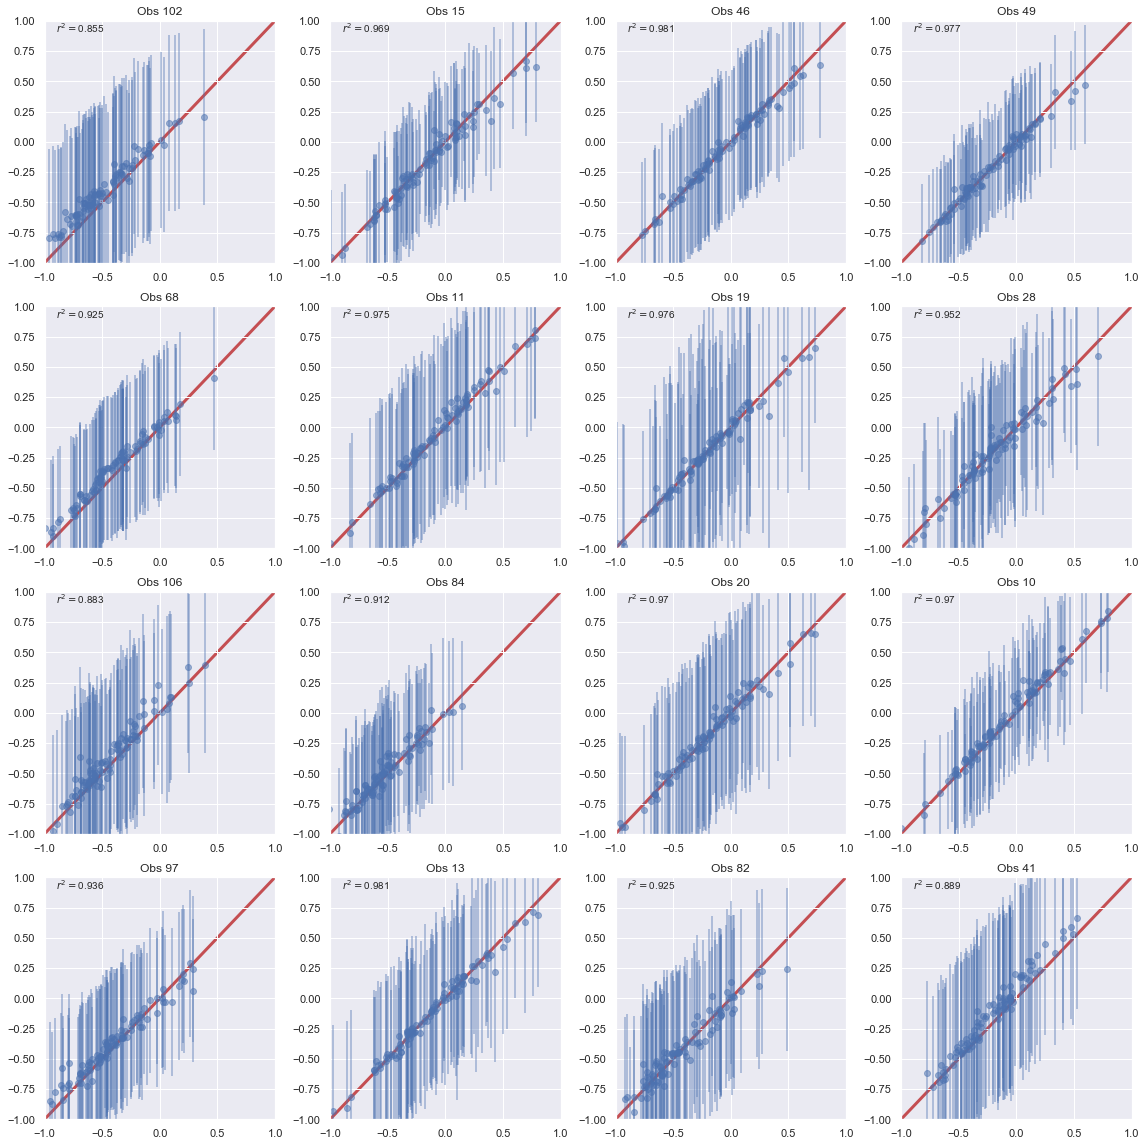

In [30]:
truth = np.linspace(-1, 1, 100)

sqrt_nplot = 4
n_plot = sqrt_nplot * sqrt_nplot
obs_indices = np.random.choice(110, n_plot, replace=False)

fig, axes = plt.subplots(sqrt_nplot, sqrt_nplot, figsize=(4*sqrt_nplot, 4*sqrt_nplot))
for i, obs_ind in enumerate(obs_indices):
    ax = axes.flatten()[i]
    ax.set_title("Obs " + str(obs_ind))
    ax.plot(truth, truth, c='r', lw=3, zorder=-1)
    ax.errorbar(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind], yerr=pred_std[:, obs_ind],
                alpha=0.5, zorder=1, fmt='o')
    
    
    r2 = r2_score(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind])
    ax.annotate(r'$r^2 = $' + str(round(r2, 3) ), xy = (-0.9, 0.9))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
plt.tight_layout(True)
plt.show()

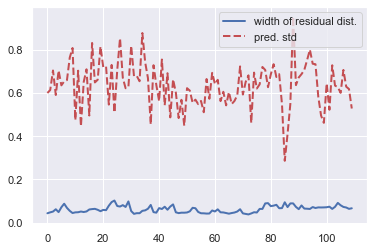

In [38]:
sigma_res_arr = []
sigma_pred_arr = []

for iobs in range(Y.shape[1]):
    res = pred_mean[:, iobs] - Y_test_sc[:, iobs]
    res = res.numpy()
    sigma_res = np.std(res)
    sigma_pred = np.mean(pred_std[:, iobs].numpy())
    sigma_res_arr.append(sigma_res)
    sigma_pred_arr.append(sigma_pred)


plt.plot(np.arange(0, Y.shape[1]), sigma_res_arr, lw=2, label='width of residual dist.')
plt.plot(np.arange(0, Y.shape[1]), sigma_pred_arr, lw=2, color='r', label='pred. std', ls='--')
plt.legend()
plt.show()

In [39]:
r2 = r2_score(Y_test_sc,pred_mean)
print("r2 = " + str(round(r2, 3)))

r2 = 0.939
